# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier
Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The [rubric](https://review.udacity.com/#!/rubrics/481/view)

Implementation based on the LeNet-5.

Here is other example approach [on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

---
## Step 0: Load The Data

In [1]:
import pandas as pd
import pickle

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


sign_names = pd.read_csv("signnames.csv")

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Some numbers

In [2]:
n_train = X_train.shape[0]

n_test = X_test.shape[0]

image_shape = X_train[0].shape

n_classes = sign_names.shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

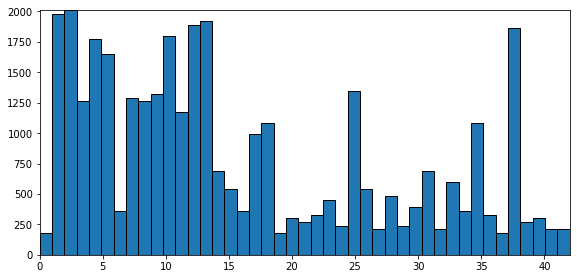

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
%matplotlib inline

fig, ax = plt.subplots()

data = train['labels']
n, bins = np.histogram(data, n_classes)

# get the corners of the rectangles for the histogram
left = np.array(bins[:-1])
right = np.array(bins[1:])
bottom = np.zeros(len(left))
top = bottom + n

# we need a (numrects x numsides x 2) numpy array for the path helper
# function to build a compound path
XY = np.array([[left, left, right, right], [bottom, top, top, bottom]]).T

# get the Path object
barpath = path.Path.make_compound_path_from_polys(XY)

# make a patch out of it
patch = patches.PathPatch(barpath)
ax.add_patch(patch)

# update the view limits
ax.set_xlim(left[0], right[-1])
ax.set_ylim(bottom.min(), top.max())

fig.set_size_inches(9.5, 4.5)
plt.show()

### Color distribution

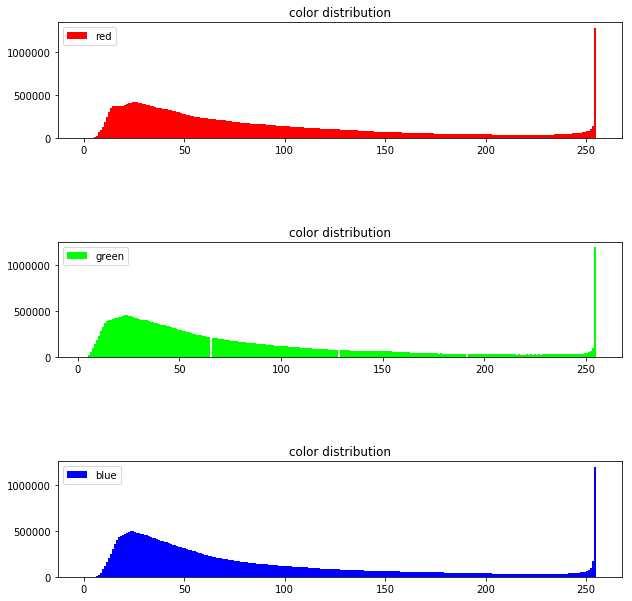

In [4]:
import matplotlib.pyplot as plt
import numpy as np

xs = [x[0] for sign in X_train for row in sign for x in row]
ys = [x[1] for sign in X_train for row in sign for x in row]
zs = [x[2] for sign in X_train for row in sign for x in row]

fig, axes = plt.subplots(nrows=3, ncols=1)
ax0, ax1, ax2 = axes.flatten()

ax0.hist(xs, 256, histtype='bar', color='red', label='red')
ax0.legend(prop={'size': 10})
ax0.set_title('color distribution')

ax1.hist(ys, 256, histtype='bar', color='lime', label='green')
ax1.legend(prop={'size': 10})
ax1.set_title('color distribution')

ax2.hist(zs, 256, histtype='bar', color='blue', label='blue')
ax2.legend(prop={'size': 10})
ax2.set_title('color distribution')

fig.tight_layout()
fig.set_size_inches(9.5, 9.5)
plt.show()


----

## Step 2: Model Architecture


## Pre-process data

### Grayscale

ClassId                                               10
SignName    No passing for vehicles over 3.5 metric tons
Name: 10, dtype: object


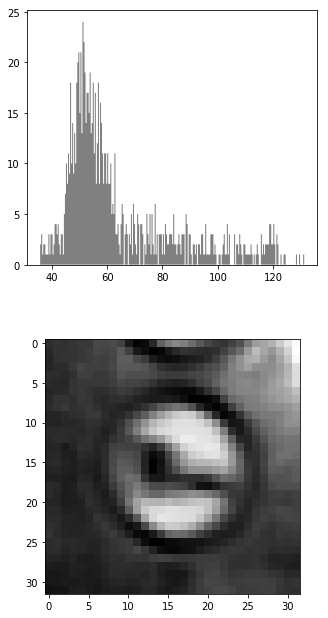

In [5]:
# %% GRAY SCALE
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def grayscale(data_set):
    gray = np.array([0.299,0.587,0.114]).reshape(3,1)
    return data_set.dot(gray)

X_train = grayscale(X_train)
X_valid = grayscale(X_valid)
X_test = grayscale(X_test)

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

print(sign_names.loc[y_train[index]])
fig, axes = plt.subplots(nrows=2, ncols=1)
ax0, ax1 = axes.flatten()

ax0.hist(image.flatten(), 256, histtype='stepfilled', color='gray', label='red')
ax1.imshow(image, cmap="gray")

fig.tight_layout()
fig.set_size_inches(4.5, 9.5)
plt.show()

### Histogram equalization

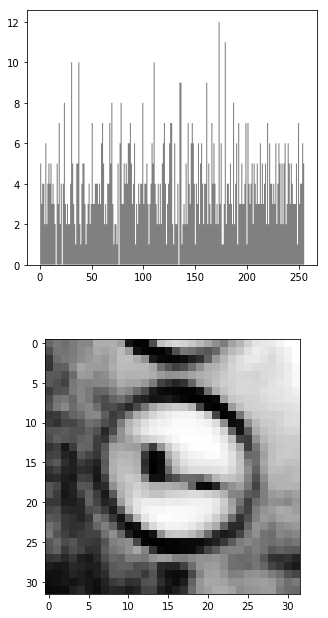

In [6]:
# %% HISTOGRAM EQUALIZATION

import numpy as np

def dataset_histogram_equalization(dataset):
    data_equalized = np.zeros(dataset.shape)
    for i in range(dataset.shape[0]):
        image = dataset[i, :, :, 0]
        data_equalized[i, :, :, 0] = image_histogram_equalization(image)[0]
    return data_equalized

def image_histogram_equalization(image, number_bins=256):
    # from http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, normed=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape), cdf

X_train = dataset_histogram_equalization(X_train)
X_valid = dataset_histogram_equalization(X_valid)
X_test = dataset_histogram_equalization(X_test)

#sample
image = X_train[index].squeeze()

fig, axes = plt.subplots(nrows=2, ncols=1)
ax0, ax1 = axes.flatten()

ax0.hist(image.flatten(), 256, histtype='stepfilled', color='gray', label='red')
ax1.imshow(image, cmap="gray")

fig.tight_layout()
fig.set_size_inches(4.5, 9.5)
plt.show()

### Min Max Scaling

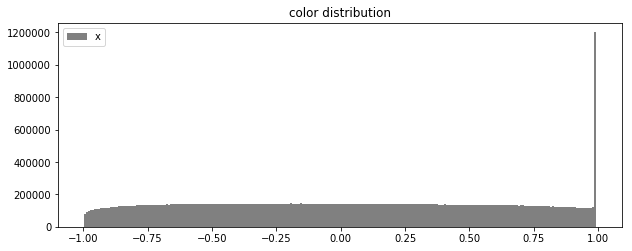

In [7]:
#MIN MAX SCALING
import matplotlib.pyplot as plt
import numpy as np

X_train = (X_train - 128) / 128
X_valid = (X_valid - 128) / 128
X_test = (X_test - 128) / 128

fig, ax = plt.subplots()
ax.hist(X_train.reshape(-1), 256, histtype='bar', color='gray', label='x')
ax.legend(prop={'size': 10})
ax.set_title('color distribution')

fig.tight_layout()
fig.set_size_inches(9.5, 3.5)
plt.show()

### Model Architecture

#### Model input

In [8]:
# %% INPUT
import tensorflow as tf

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
is_train = tf.placeholder(tf.bool, shape=[])

#### Model definition

In [9]:
# %% DEFINITION
from tensorflow.contrib.layers import flatten

mu = 0
sigma = 0.1

#Layer 1: Convolutional. Input = 32x32x1. Output = 32x32x32.
c1_weights = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 32), mean = mu, stddev = sigma))
c1_bias = tf.Variable(tf.zeros(32))
c1 = tf.nn.conv2d(x, c1_weights, strides=[1, 1, 1, 1], padding='SAME') + c1_bias
#Activation.
c1 = tf.nn.relu(c1)
#Pooling. Input = 32x32x32. Output = 16x16x32.
c1 = tf.nn.max_pool(c1, ksize = [1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
#Dropout
c1 = tf.cond(is_train, lambda: tf.nn.dropout(c1, keep_prob = 0.9), lambda: c1)

#Layer 2: Convolutional. Input = 16x16x32. Output = 16x16x64.
c2_weights = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma))
c2_bias = tf.Variable(tf.zeros(64))
c2 = tf.nn.conv2d(c1, c2_weights, strides=[1, 1, 1, 1], padding='SAME') + c2_bias
#Activation.
c2 = tf.nn.relu(c2)
#Pooling.  Input = 16x16x64. Output = 8x8x64.
c2 = tf.nn.max_pool(c2, ksize = [1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
#Dropout
c2 = tf.cond(is_train, lambda: tf.nn.dropout(c2, keep_prob = 0.8), lambda: c2)

#Layer 3: Convolutional. Input = 8x8x64. Output = 6x6x128.
c3_weights = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = mu, stddev = sigma))
c3_bias = tf.Variable(tf.zeros(128))
c3 = tf.nn.conv2d(c2, c3_weights, strides=[1, 1, 1, 1], padding='VALID') + c3_bias
#Activation.
c3 = tf.nn.relu(c3)
#Dropout
c3 = tf.cond(is_train, lambda: tf.nn.dropout(c3, keep_prob = 0.7), lambda: c3)

#Layer 4: Convolutional. Input = 6x6x128. Output = 4x4x256.
c4_weights = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 256), mean = mu, stddev = sigma))
c4_bias = tf.Variable(tf.zeros(256))
c4 = tf.nn.conv2d(c3, c4_weights, strides=[1, 1, 1, 1], padding='VALID') + c4_bias
#Activation.
c4 = tf.nn.relu(c4)
#Pooling. Input = 4x4x256. Output = 2x2x256.
c4 = tf.nn.max_pool(c4, ksize = [1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
#Dropout
c4 = tf.cond(is_train, lambda: tf.nn.dropout(c4, keep_prob = 0.6), lambda: c4)

#Layer 5: Convolutional. Input = 2x2x256. Output = 1x1x512.
c5_weights = tf.Variable(tf.truncated_normal(shape=(2, 2, 256, 512), mean = mu, stddev = sigma))
c5_bias = tf.Variable(tf.zeros(512))
c5 = tf.nn.conv2d(c4, c5_weights, strides=[1, 1, 1, 1], padding='VALID') + c5_bias
#Activation.
c5 = tf.nn.relu(c5)
#Dropout
c5 = tf.cond(is_train, lambda: tf.nn.dropout(c5, keep_prob = 0.5), lambda: c5)

#Flatten. Input = 1x1x512. Output = 512.
flat = flatten(c5)

#Layer 6: Fully Connected. Input = 512. Output = 1024.
f1_weights = tf.Variable(tf.truncated_normal(shape=(512,1024), mean = mu, stddev = sigma))
f1_bias = tf.Variable(tf.zeros(1024))
f1 = tf.matmul(flat,f1_weights) + f1_bias
#Activation.
f1 = tf.nn.relu(f1)
#Dropout
f1 = tf.cond(is_train, lambda: tf.nn.dropout(f1, keep_prob = 0.5), lambda: f1)

#Layer 7: Fully Connected. Input = 1024. Output = 43.
out_weights =  tf.Variable(tf.truncated_normal(shape=(1024,43), mean = mu, stddev = sigma))
out_bias = tf.Variable(tf.zeros(43))
out = tf.matmul(f1,out_weights) + out_bias
    


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

#### Training Pipeline


In [10]:
# %% TRAINING PIPELINE
rate = 0.0001

logits = out

one_hot_y = tf.one_hot(y, 43)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits,labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

#### Model Evaluation

In [11]:
# %% MODEL EVALUATION
EPOCHS = 360
BATCH_SIZE = 64

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, is_train: False})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#### Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the accuracy of the validation set.

Save the model with best vadlidation accuracy after training.


In [12]:
# %% TRAINING MODEL
import os
from sklearn.utils import shuffle

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    train_error = []
    valid_error = []
    
    best_accuracy = 0.99 #set minimum goal
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, is_train: True})

        train_accuracy = evaluate(X_train, y_train)
        train_error.append(train_accuracy)
        validation_accuracy = evaluate(X_valid, y_valid)
        valid_error.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
        if validation_accuracy > best_accuracy:
            saver.save(sess,'sign-net')
            best_accuracy = validation_accuracy
            print("Model saved: "+ str(best_accuracy))
            print()
    
    print("End training, best model: "+ str(best_accuracy))

Training...

EPOCH 1 ...
Validation Accuracy = 0.059

EPOCH 2 ...
Validation Accuracy = 0.054

EPOCH 3 ...
Validation Accuracy = 0.055

EPOCH 4 ...
Validation Accuracy = 0.055

EPOCH 5 ...
Validation Accuracy = 0.054

EPOCH 6 ...
Validation Accuracy = 0.054

EPOCH 7 ...
Validation Accuracy = 0.072

EPOCH 8 ...
Validation Accuracy = 0.088

EPOCH 9 ...
Validation Accuracy = 0.144

EPOCH 10 ...
Validation Accuracy = 0.195

EPOCH 11 ...
Validation Accuracy = 0.260

EPOCH 12 ...
Validation Accuracy = 0.294

EPOCH 13 ...
Validation Accuracy = 0.318

EPOCH 14 ...
Validation Accuracy = 0.366

EPOCH 15 ...
Validation Accuracy = 0.447

EPOCH 16 ...
Validation Accuracy = 0.489

EPOCH 17 ...
Validation Accuracy = 0.513

EPOCH 18 ...
Validation Accuracy = 0.544

EPOCH 19 ...
Validation Accuracy = 0.591

EPOCH 20 ...
Validation Accuracy = 0.620

EPOCH 21 ...
Validation Accuracy = 0.652

EPOCH 22 ...
Validation Accuracy = 0.694

EPOCH 23 ...
Validation Accuracy = 0.715

EPOCH 24 ...
Validation Accura

#### Test the model

In [15]:
# %% TESTING MODEL
import tensorflow as tf
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('sign-net.meta', clear_devices=True)
    new_saver.restore(sess,  tf.train.latest_checkpoint('.'))
    
    train_accouracy = evaluate(X_train, y_train)
    print("Training Accuracy = {:.3f}".format(train_accouracy))
    
    validation_accuracy = evaluate(X_valid, y_valid)
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Training Accuracy = 1.000
Validation Accuracy = 0.994
Test Accuracy = 0.970


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

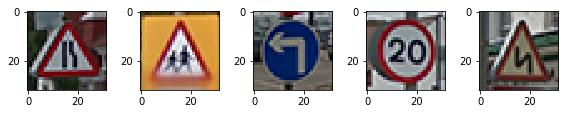

In [16]:
# %% LOAD SAMPLES

import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
from scipy import misc

from os import listdir
from os.path import isfile, join

def display_samples(images, cmap = None):
    cols = 5
    rows = int(math.ceil(len(images) / cols))
    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure(figsize=(8, 3))
    
    for i, img in enumerate(images):
        sub = fig.add_subplot(gs[i])
        sub.imshow(img, cmap)
        
    fig.tight_layout()


def load_data(data_dir):
    onlyfiles = [n for n in listdir(data_dir) if isfile(join(data_dir, n))]
    images = []
    for n in onlyfiles:
        img = misc.imread(os.path.join(data_dir, n), mode = 'RGB')
        images.append(img)
    return np.array(images)

images_to_display = load_data('samples')
display_samples(images_to_display)



### Predict the Sign Type for Each Image

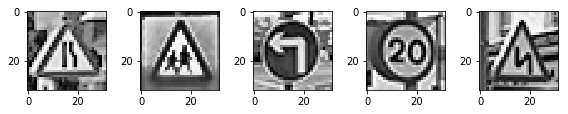

In [17]:
# %% PREPROCESS SAMPLES
import numpy as np
          
images = grayscale(images_to_display)
images = dataset_histogram_equalization(images)
display_samples([img.squeeze() for img in images], cmap='gray')

images = (images - 128) / 128 #MIN MAX SCALING

In [31]:
performance = 0
sample_ids = [24, 28, 34, 0 ,21]

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('sign-net.meta', clear_devices=True)
    new_saver.restore(sess,  tf.train.latest_checkpoint('.'))
    
    best = tf.argmax(tf.nn.softmax(logits),1)
    sess = tf.get_default_session()
    results = sess.run(best, feed_dict={x: images, is_train: False})
    
    for id, res in zip(sample_ids, results):
        if id == res:
            performance += 1

print("Predicted correctly: "+ str(performance))

Predicted correctly: 5


### Analyze Performance

In [22]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
print("Performance: {:.1f}%".format(performance / 5 * 100))

Performance: 100.0%


### Top 5 Softmax Probabilities

For each of the new images, I print out the model's softmax probabilities to show the **certainty** of the model's predictions. 

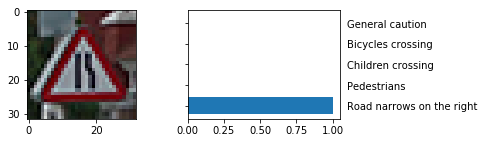

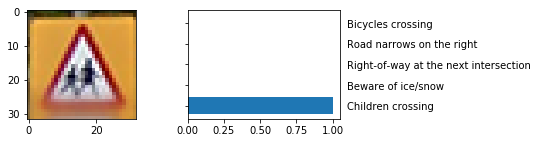

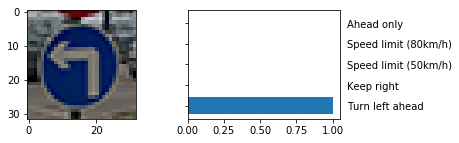

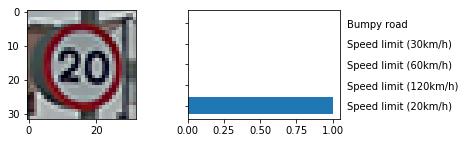

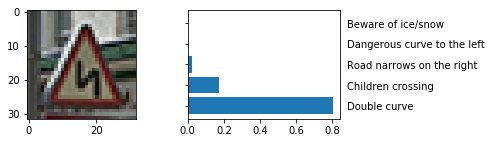

In [33]:
# %% TOP 5 FOR SAMPLES
def plot_result(index, results) :
    fig = plt.figure(figsize = (6, 2))
    gs = gridspec.GridSpec(1, 2)
    
    sub = fig.add_subplot(gs[0])
    plt.imshow(images_to_display[index])
    
    sub = fig.add_subplot(gs[1])
    plt.barh(np.arange(5)+.5, results[0][index], align='center')    
    plt.yticks(np.arange(5)+.5, map((lambda i: sign_names.loc[i][1]), results[1][index].astype(int)))
    plt.tick_params(axis='both', which='both', labelleft='off', labelright='on', labeltop='off', labelbottom='on')
    
    
    plt.show()
    fig.tight_layout()

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('sign-net.meta', clear_devices=True)
    new_saver.restore(sess,  tf.train.latest_checkpoint('.'))
    
    best_five = tf.nn.top_k(tf.nn.softmax(logits), k = 5)
    sess = tf.get_default_session()
    results = sess.run(best_five, feed_dict={x: images, is_train: False})
    
    for i in range(5):
        plot_result(i,results)

---

## Step 4: Visualize the Neural Network's State with Test Images

  While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without.

In [34]:
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, is_train: False})
    featuremaps = min(activation.shape[3],48)
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

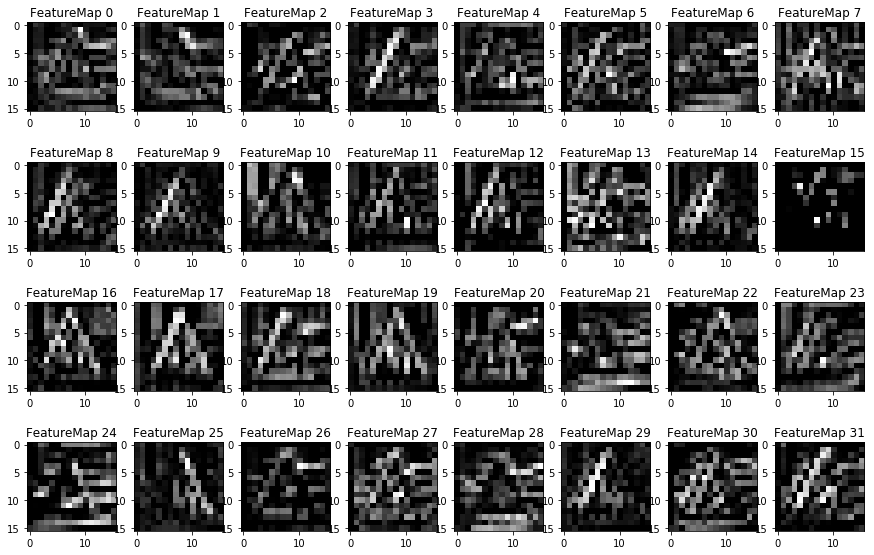

In [38]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('sign-net.meta', clear_devices=True)
    new_saver.restore(sess,  tf.train.latest_checkpoint('.'))
    
    outputFeatureMap([images[4]], c1)

### TODO

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images.

Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.


**Answer:**